In [7]:
from map_color_element import *
from utils import *

In [8]:
img = read_img('basic_map.png')

In [27]:
MAP_ELEMENTS = [
    MapColorElement('path', np.array([127, 127, 127]), externalBlurSigma=4, forceToEnter=1, forceToLeave=-1),
    MapColorElement('grass', np.array([34, 177, 76]), externalBlurSigma=4, forceToEnter=1, forceToLeave=1),
    MapColorElement('obstacle', np.array([255, 255, 255]), externalBlurSigma=2, forceToEnter=-4096, forceToLeave=8)
    # MapColorElement('red', np.array([237, 28, 36]), blurSigma=16, forceToEnter=1, forceToLeave=1),
    # MapColorElement('blue', np.array([63, 72, 204]), blurSigma=16, forceToEnter=1, forceToLeave=1)
]

In [28]:
field = get_total_field(img, MAP_ELEMENTS)

In [29]:
# normalized = normalize_field(field)

In [32]:
!python parse_map.py --mapdir ../src/assets/maps/basic

field.ts already exists in ../src/assets/maps/basic
	deleting...


In [24]:
pixels = np.linspace(0, 512, 512, endpoint=False).astype(int)
x, y = np.meshgrid(pixels, pixels)
center = (75,125)
lim = 75

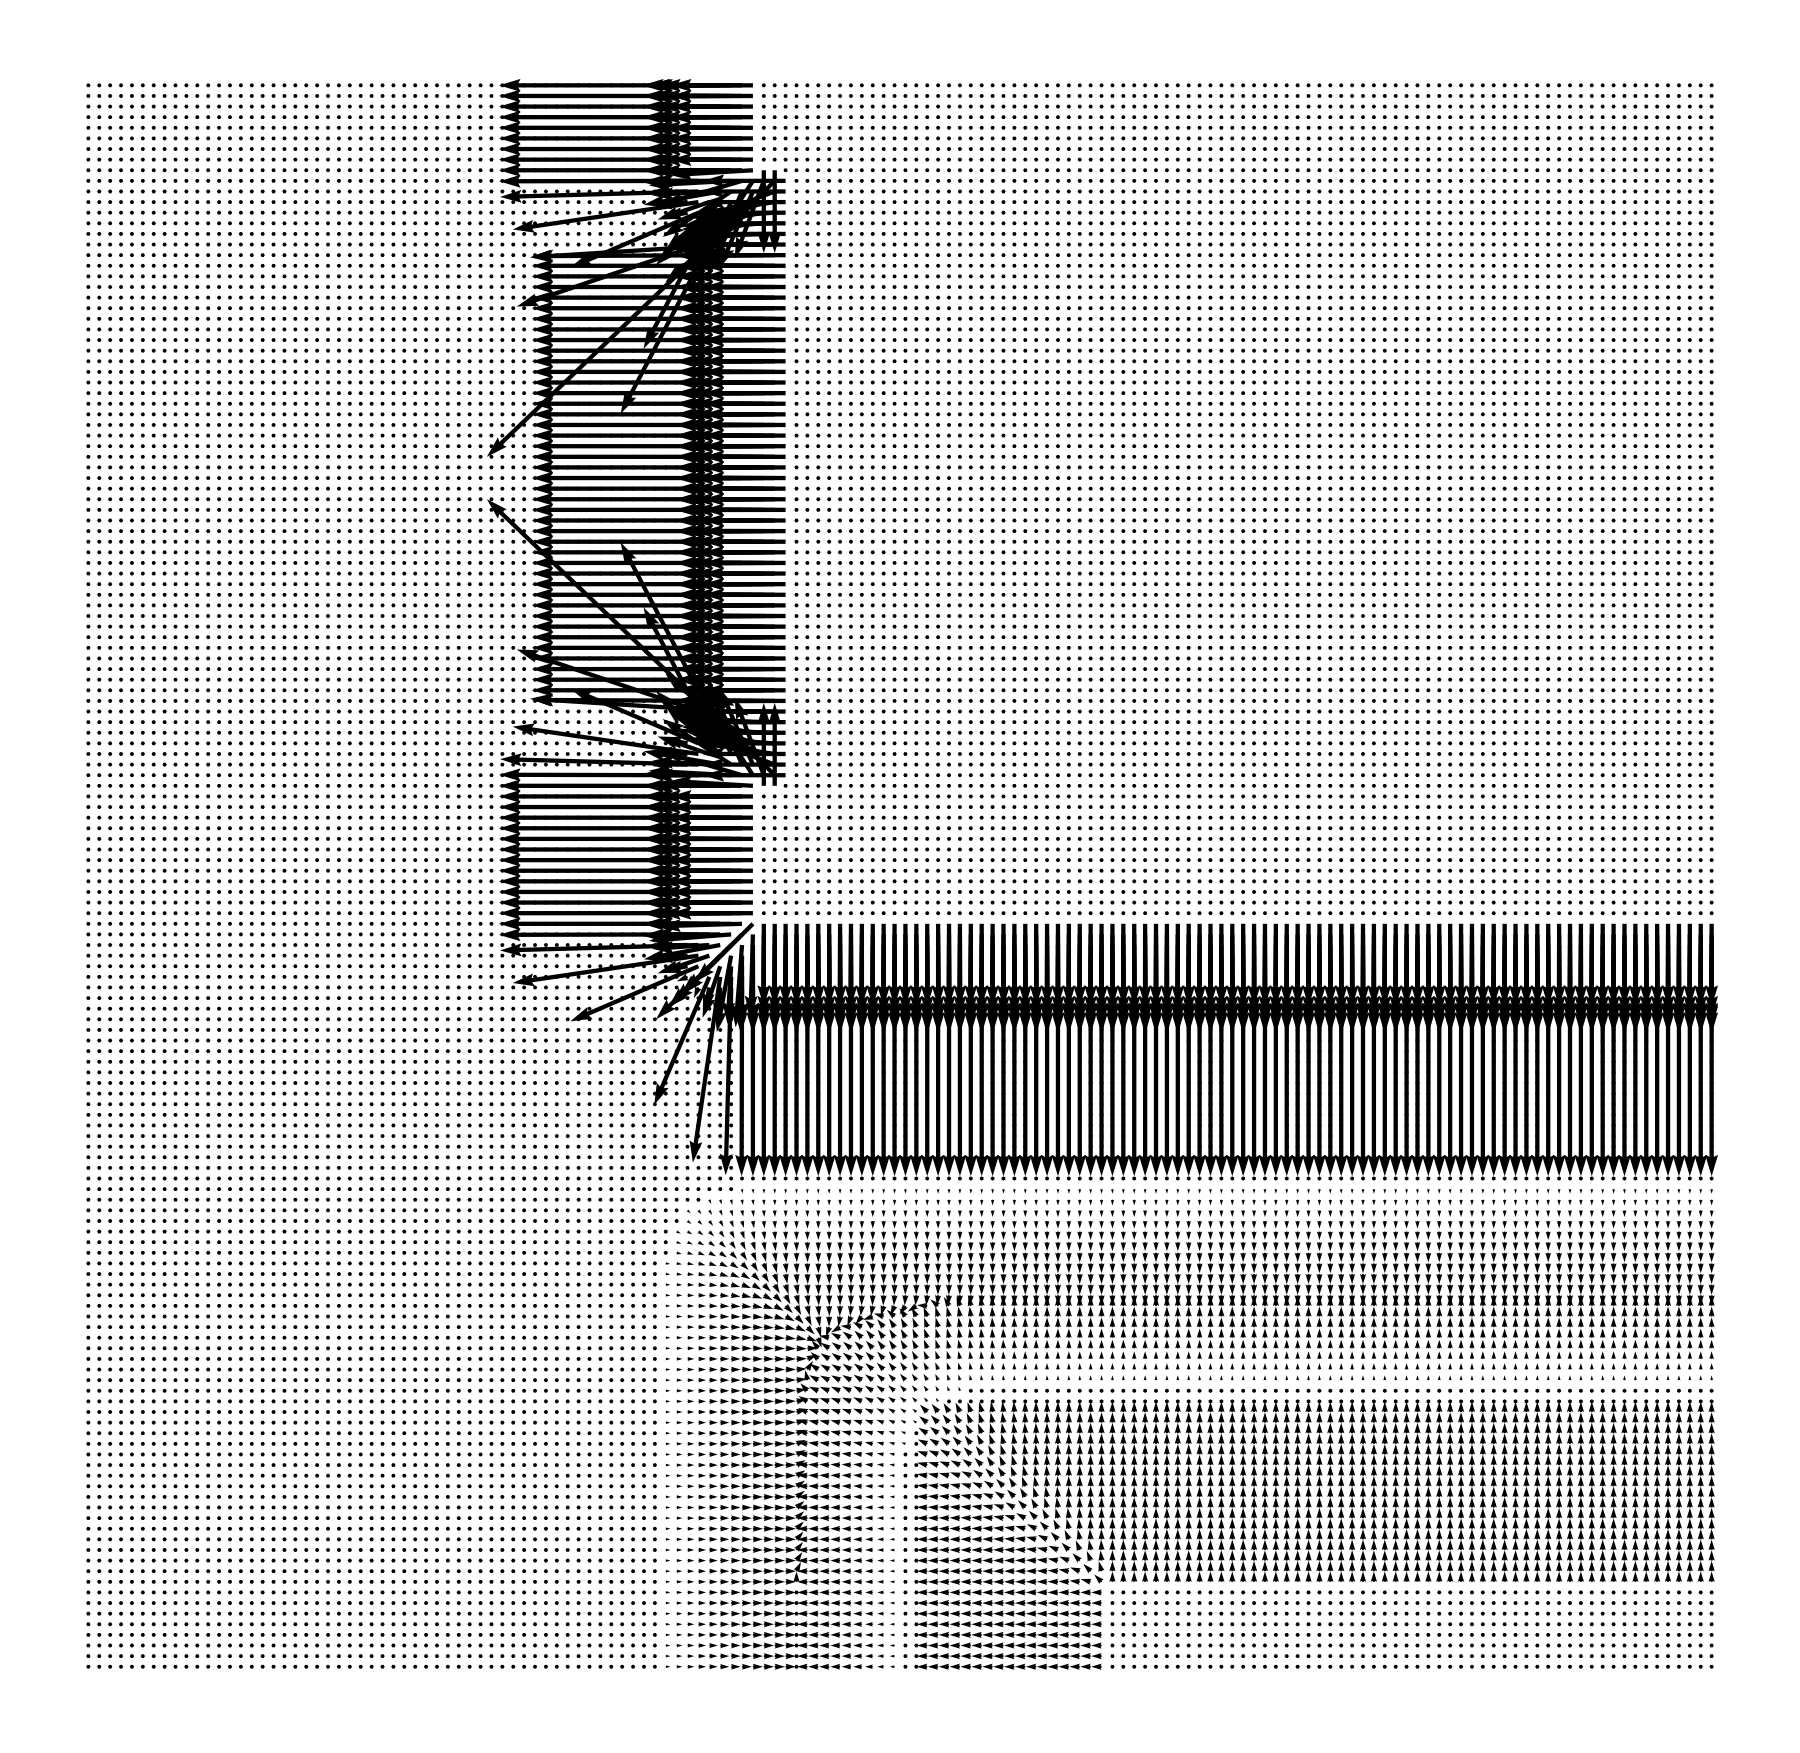

In [25]:
plt.figure(figsize=(32,32))
plt.quiver(crop(x,center,lim), crop(y,center,lim)[::-1], crop(field[:,:,0], center, lim), crop(field[:,:,1], center, lim))
plt.axis('off')
plt.show()